In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from collections import Counter
from scipy.sparse import csr_matrix, find
import numpy as np
from sklearn.cluster import KMeans
import numpy as np
import random
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.utils import shuffle
from sklearn.metrics import calinski_harabaz_score
pd.options.display.max_columns = 100000
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

In [3]:
df_reviews = pd.read_csv(r'0429_places_rating_count_categories.csv', header = 0, sep =',')
df_reviews[0:5]

,name,gPlusPlaceId,latitude,longitude,rating,count,categaries
0,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Cleaning Service
1,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Carpet Cleaning Service
2,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Computer Repair Service
3,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Electronics Store
4,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Cell Phone Store


In [4]:
df_reviews[df_reviews['categaries'] == 'Restaurant'][:5]

,name,gPlusPlaceId,latitude,longitude,rating,count,categaries
24,b'El Jardin Restaurant & Tequila Bar',107031687022002436775,37.319359,-121.947853,3.571429,7,Restaurant
65,b'Five Star Falafel',104541537974160909617,37.352537,-121.982413,3.666667,6,Restaurant
130,b'Pho Hoa',101216481787477158457,37.352193,-121.992280,3.300000,10,Restaurant
143,b'Original Pancake House',117858416706070221652,37.298589,-122.032050,3.666667,3,Restaurant
172,b'Hawaiian BBQ',116873324100876387732,37.236803,-121.801645,5.000000,2,Restaurant


In [5]:
print(len(df_reviews))

18791


In [6]:
sorted_categaries = df_reviews.groupby('categaries', as_index = False).count().sort_values(['gPlusPlaceId'], ascending=False)

In [7]:
sorted_categaries[:100]

,categaries,name,gPlusPlaceId,latitude,longitude,rating,count
93,Asian Restaurant,628,628,624,624,628,628
1197,Restaurant,564,564,554,554,564,564
554,Fast Food Restaurant,443,443,441,441,443,443
928,Mexican Restaurant,326,326,326,326,326,326
835,Latin American Restaurant,279,279,279,279,279,279
45,American Restaurant,266,266,266,266,266,266
529,European Restaurant,255,255,252,252,255,255
307,Chinese Restaurant,246,246,243,243,246,246
333,Coffee Shop,239,239,238,238,239,239
1229,Sandwich Shop,208,208,206,206,208,208


In [8]:
sorted_categaries.shape

(1597, 7)

In [9]:
df_places = pd.read_csv(r'places_scc.csv', header = 0, sep = '\t')

In [10]:
df_places[:5]

,name,gPlusPlaceId,latitude,longitude
0,b'Merry Maids',116167008685876949080,37.428433,-122.072381
1,b'ClickAway',109313049343702688278,37.397753,-122.107742
2,b'Arroyo Animal Clinic',105002697535923134513,37.352790,-122.003012
3,b'Williams Cutlery & Gifts',110907461902274791474,37.261032,-121.928556
4,b'Kenzo Sushi',108154014110798888312,37.254326,-121.831140


In [11]:
gPlusPlaceId = df_places.gPlusPlaceId.tolist()
print(len(gPlusPlaceId))

10727


In [12]:
categories = sorted_categaries.categaries.tolist()
print(len(categories))

1597


In [13]:
df_one_hot_raw = pd.DataFrame(index = gPlusPlaceId, columns = categories)

In [14]:
df_one_hot_raw = df_one_hot_raw.fillna(0)

In [15]:
df_one_hot_raw.shape

(10727, 1597)

In [16]:
count = 0
for index in range(0, len(df_reviews)):
    gPlusPlaceId = df_reviews.loc[index, 'gPlusPlaceId']
    categaries   = df_reviews.loc[index, 'categaries']
    df_one_hot_raw.loc[gPlusPlaceId][categaries] = 1
    count = count + 1
print(count)

18791


In [17]:
df_one_hot_raw.shape

(10727, 1597)

In [18]:
df_one_hot_raw[:10]

Asian Restaurant  Restaurant  Fast Food Restaurant  \
116167008685876949080                 0           0                     0   
109313049343702688278                 0           0                     0   
105002697535923134513                 0           0                     0   
110907461902274791474                 0           0                     0   
108154014110798888312                 0           0                     0   
110125337790407704048                 1           0                     0   
103114189185128172191                 0           0                     0   
103270878986977603400                 0           0                     0   
112617725763412100058                 0           0                     0   
106229285421487980307                 0           0                     0   

                       Mexican Restaurant  Latin American Restaurant  \
116167008685876949080                   0                          0   
109313049343702688278                   0                          0   
105002697535923134513                   0                          0   
110907461902274791474                   0                          0   
108154014110798888312                   0                          0   
110125337790407704048                   0                          0   
103114189185128172191                   0                          0   
103270878986977603400                   0                          0   
112617725763412100058                   0                          0   
106229285421487980307                   0                          0   

                       American Restaurant  European Restaurant  \
116167008685876949080                    0                    0   
109313049343702688278                    0                    0   
105002697535923134513                    0                    0   
110907461902274791474                    0                    0   
108154014110798888312                    0                    0   
110125337790407704048                    0                    0   
103114189185128172191                    0                    0   
103270878986977603400                    0                    0   
112617725763412100058                    0                    0   
106229285421487980307                    0                    0   

                       Chinese Restaurant  Coffee Shop  Sandwich Shop  Park  \
116167008685876949080                   0            0              0     0   
109313049343702688278                   0            0              0     0   
105002697535923134513                   0            0              0     0   
110907461902274791474                   0            0              0     0   
108154014110798888312                   0            0              0     0   
110125337790407704048                   1            0              0     0   
103114189185128172191                   0            0              0     0   
103270878986977603400                   0            0              0     0   
112617725763412100058                   0            0              0     0   
106229285421487980307                   0            0              0     0   

                       Pizza Restaurant  Japanese Restaurant  \
116167008685876949080                 0                    0   
109313049343702688278                 0                    0   
105002697535923134513                 0                    0   
110907461902274791474                 0                    0   
108154014110798888312                 0                    1   
110125337790407704048                 0                    0   
103114189185128172191                 0                    0   
103270878986977603400                 0                    0   
112617725763412100058                 0                    0   
106229285421487980307                 0                    0   

                       Italian Restaurant  Beauty Salon  Auto Repair 

In [19]:
kValues = list()
scores = list()
mat = df_one_hot_raw.values
for index in range(3, 200, 2):
    km = KMeans(n_clusters = index, max_iter = 1000, tol = 0.0001, verbose = 0, random_state = None)
    km.fit(mat)
    labels = km.labels_
    score = calinski_harabaz_score(mat, labels)
    kValues.append(index)
    scores.append(score)
    print ("For K= %d Calinski Harabaz Score is %f" %(index, score))

For K= 3 Calinski Harabaz Score is 399.048635
For K= 5 Calinski Harabaz Score is 305.897828
For K= 7 Calinski Harabaz Score is 204.574042
For K= 9 Calinski Harabaz Score is 215.316506
For K= 11 Calinski Harabaz Score is 241.101075
For K= 13 Calinski Harabaz Score is 220.507391
For K= 15 Calinski Harabaz Score is 204.642032
For K= 17 Calinski Harabaz Score is 191.318249
For K= 19 Calinski Harabaz Score is 192.199753
For K= 21 Calinski Harabaz Score is 182.669541
For K= 23 Calinski Harabaz Score is 174.992820
For K= 25 Calinski Harabaz Score is 161.978185
For K= 27 Calinski Harabaz Score is 168.549832
For K= 29 Calinski Harabaz Score is 157.315352
For K= 31 Calinski Harabaz Score is 155.691352
For K= 33 Calinski Harabaz Score is 154.550442
For K= 35 Calinski Harabaz Score is 144.655104
For K= 37 Calinski Harabaz Score is 145.539327
For K= 39 Calinski Harabaz Score is 142.960840
For K= 41 Calinski Harabaz Score is 139.932479
For K= 43 Calinski Harabaz Score is 135.523536
For K= 45 Calinsk

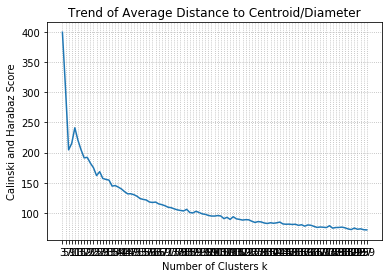

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(kValues, scores)
plt.xticks(kValues, kValues)
plt.xlabel('Number of Clusters k')
plt.ylabel('Calinski and Harabaz Score')
plt.title('Trend of Average Distance to Centroid/Diameter')
plt.grid(linestyle='dotted')
plt.savefig('plot_kmean.png')
plt.show()

In [37]:
import collections
kValues = list()
scores = list()
last = 0
mat = df_one_hot_raw.values
for index in range(3, 300, 20):
    km = KMeans(n_clusters = index, max_iter = 1000, tol = 0.0001, verbose = 0, random_state = None)
    km.fit(mat)
    labels = km.labels_
    counter = collections.Counter(labels)
    kValues.append(index)
    #kValues.append(index)
    scores.append(counter.most_common(1)[0][1])
    if index == 299:
        last = counter.most_common(1)[0][1]
    #print ("For K= %d Calinski Harabaz Score is %f" %(index, score))

In [36]:
print(last)

3806


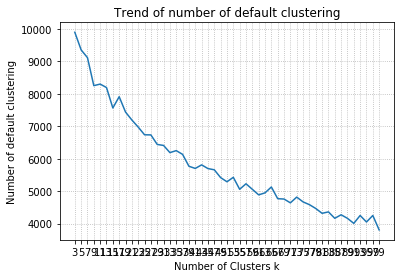

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(kValues, scores)
plt.xticks(kValues, kValues)
plt.xlabel('Number of Clusters k')
plt.ylabel('Number of default clustering')
plt.title('Trend of number of default clustering')
plt.grid(linestyle='dotted')
plt.savefig('plot_kmean.png')
plt.show()

In [319]:
# df_type_set = pd.DataFrame()
# df_type_set['gPlusPlaceId'] = df_places.gPlusPlaceId

In [320]:
# df_type_set[:5]

In [321]:
# for index in range(0, 40):
#     print(index)
#     mat = df_one_hot_raw.values
#     km = KMeans(n_clusters = 50, max_iter = 10000, tol = 0.0001, verbose = 0, random_state = None)
#     km.fit(mat)
#     labels = km.labels_
#     df_type_set[index] = labels

In [322]:
# df_type_set

In [327]:
df_one_hot_raw[:10]

Asian Restaurant  Restaurant  Fast Food Restaurant  \
116167008685876949080                 0           0                     0   
109313049343702688278                 0           0                     0   
105002697535923134513                 0           0                     0   
110907461902274791474                 0           0                     0   
108154014110798888312                 0           0                     0   
110125337790407704048                 1           0                     0   
103114189185128172191                 0           0                     0   
103270878986977603400                 0           0                     0   
112617725763412100058                 0           0                     0   
106229285421487980307                 0           0                     0   

                       Mexican Restaurant  Latin American Restaurant  \
116167008685876949080                   0                          0   
109313049343702688278                   0                          0   
105002697535923134513                   0                          0   
110907461902274791474                   0                          0   
108154014110798888312                   0                          0   
110125337790407704048                   0                          0   
103114189185128172191                   0                          0   
103270878986977603400                   0                          0   
112617725763412100058                   0                          0   
106229285421487980307                   0                          0   

                       American Restaurant  European Restaurant  \
116167008685876949080                    0                    0   
109313049343702688278                    0                    0   
105002697535923134513                    0                    0   
110907461902274791474                    0                    0   
108154014110798888312                    0                    0   
110125337790407704048                    0                    0   
103114189185128172191                    0                    0   
103270878986977603400                    0                    0   
112617725763412100058                    0                    0   
106229285421487980307                    0                    0   

                       Chinese Restaurant  Coffee Shop  Sandwich Shop  Park  \
116167008685876949080                   0            0              0     0   
109313049343702688278                   0            0              0     0   
105002697535923134513                   0            0              0     0   
110907461902274791474                   0            0              0     0   
108154014110798888312                   0            0              0     0   
110125337790407704048                   1            0              0     0   
103114189185128172191                   0            0              0     0   
103270878986977603400                   0            0              0     0   
112617725763412100058                   0            0              0     0   
106229285421487980307                   0            0              0     0   

                       Pizza Restaurant  Japanese Restaurant  \
116167008685876949080                 0                    0   
109313049343702688278                 0                    0   
105002697535923134513                 0                    0   
110907461902274791474                 0                    0   
108154014110798888312                 0                    1   
110125337790407704048                 0                    0   
103114189185128172191                 0                    0   
103270878986977603400                 0                    0   
112617725763412100058                 0                    0   
106229285421487980307                 0                    0   

                       Italian Restaurant  Beauty Salon  Auto Repair 

In [328]:
df_one_hot_raw.shape

(10727, 1597)

In [329]:
mat = df_one_hot_raw.values
km = KMeans(n_clusters = 200, max_iter = 100000, tol = 0.0001, verbose = 0, random_state = None)
km.fit(mat)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100000,
    n_clusters=200, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [163]:
# df_one_hot_raw_T = df_one_hot_raw.T

In [164]:
# df_one_hot_raw_T.shape

In [165]:
# df_one_hot_raw_T[:5]

In [166]:
# mat_T = df_one_hot_raw_T.values
# km_T = KMeans(n_clusters = 20, max_iter = 100000, tol = 0.0001, verbose = 0, random_state = None)
# km_T.fit(mat_T)

In [167]:
# from sklearn.cluster import MeanShift
# mat = df_one_hot_raw.values
# clustering = MeanShift(bandwidth=2).fit(mat)

In [168]:
# print(len(km_T.labels_))

In [169]:
# df_one_hot_T = pd.DataFrame()
# df_one_hot_T['categories'] = sorted_categaries.categaries
# df_one_hot_T['type'] = km_T.labels_

In [51]:
# df_one_hot_T[:100]

In [52]:
# df_one_hot_T[df_one_hot_T['type'] == 0]

In [330]:
df_one_hot = pd.DataFrame()
df_one_hot['gPlusPlaceId'] = df_places.gPlusPlaceId
df_one_hot['type'] = km.labels_

In [331]:
df_one_hot[:10]

,gPlusPlaceId,type
0,116167008685876949080,121
1,109313049343702688278,169
2,105002697535923134513,71
3,110907461902274791474,148
4,108154014110798888312,10
5,110125337790407704048,4
6,103114189185128172191,48
7,103270878986977603400,96
8,112617725763412100058,166
9,106229285421487980307,166


In [257]:
# col_n = ['type']
# df_places_clustering = pd.DataFrame(df_one_hot,columns = col_n)
# df_places_clustering['gPlusPlaceId'] = df_places_clustering.index
# df_places_clustering[:5]

In [332]:
df_places_final = pd.merge(df_places, df_one_hot, how = 'left', on = 'gPlusPlaceId')

In [333]:
df_places_final[:5]

,name,gPlusPlaceId,latitude,longitude,type
0,b'Merry Maids',116167008685876949080,37.428433,-122.072381,121
1,b'ClickAway',109313049343702688278,37.397753,-122.107742,169
2,b'Arroyo Animal Clinic',105002697535923134513,37.352790,-122.003012,71
3,b'Williams Cutlery & Gifts',110907461902274791474,37.261032,-121.928556,148
4,b'Kenzo Sushi',108154014110798888312,37.254326,-121.831140,10


In [334]:
df_reviews[:5]

,name,gPlusPlaceId,latitude,longitude,rating,count,categaries
0,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Cleaning Service
1,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Carpet Cleaning Service
2,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Computer Repair Service
3,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Electronics Store
4,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Cell Phone Store


In [335]:
df_reviews.shape

(18791, 7)

In [336]:
df_reviews_final = pd.merge(df_reviews, df_one_hot, how = 'left', on = 'gPlusPlaceId')

In [337]:
df_reviews_final[:10]

,name,gPlusPlaceId,latitude,longitude,rating,count,categaries,type
0,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Cleaning Service,121
1,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Carpet Cleaning Service,121
2,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Computer Repair Service,169
3,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Electronics Store,169
4,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Cell Phone Store,169
5,b'Arroyo Animal Clinic',105002697535923134513,37.352790,-122.003012,5.000000,2,Animal Hospital,71
6,b'Arroyo Animal Clinic',105002697535923134513,37.352790,-122.003012,5.000000,2,Veterinarian,71
7,b'Williams Cutlery & Gifts',110907461902274791474,37.261032,-121.928556,5.000000,2,Home Goods Store,148
8,b'Williams Cutlery & Gifts',110907461902274791474,37.261032,-121.928556,5.000000,2,Cutlery Store,148
9,b'Williams Cutlery & Gifts',110907461902274791474,37.261032,-121.928556,5.000000,2,Sharpening Service,148


In [338]:
df_reviews_final.to_csv("r'4029_categories_clustering_200.csv'",index = False,sep = ',')

In [339]:
#df_reviews_final[df_reviews_final['categaries'] == 'Restaurant'].groupby(['type']).count().sort_values(['name'], ascending=False)

In [266]:
type_retype_dict = pd.read_csv(r'4029_retype_200_30.csv', header = 0, sep =',')

In [269]:
type_retype_dict['type'] = type_retype_dict.typeId

In [270]:
type_retype_dict[:10]

,typeId,retypes,type
0,0,4,0
1,1,27,1
2,2,26,2
3,3,27,3
4,4,27,4
5,5,27,5
6,6,27,6
7,7,27,7
8,8,5,8
9,9,5,9


In [271]:
df_reviews_final_with_retype = pd.merge(df_reviews_final, type_retype_dict, how = 'right', on = 'type')

In [272]:
df_reviews_final_with_retype.shape

(18791, 10)

In [276]:
df_reviews_final_with_retype[:100]

,name,gPlusPlaceId,latitude,longitude,rating,count,categaries,type,typeId,retypes
0,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Cleaning Service,60,60,22
1,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Carpet Cleaning Service,60,60,22
2,b'Dry Carpet Cleaning',104154342785321572384,37.353966,-121.952999,4.750000,8,Carpet Cleaning Service,60,60,22
3,b'Stanley Steemer Of San Jose',107496145987374035142,37.390296,-121.896105,4.142857,7,Carpet Cleaning Service,60,60,22
4,b'Quick Dry',117021388421498077959,37.068852,-121.610807,5.000000,1,Carpet Cleaning Service,60,60,22
5,b'Green Master Cleaning Milpitas',115732480504683158544,37.427530,-121.909145,5.000000,3,Carpet Cleaning Service,60,60,22
6,b'Green Master Cleaning Milpitas',115732480504683158544,37.427530,-121.909145,5.000000,3,House Cleaning Service,60,60,22
7,b'Heavenly Touch Carpet & Upholstery Cleaning',106381111762522912804,37.313846,-121.889730,4.428571,7,Carpet Cleaning Service,60,60,22
8,b'Heavenly Touch Carpet & Upholstery Cleaning',106381111762522912804,37.313846,-121.889730,4.428571,7,Upholstery Cleaning Service,60,60,22
9,b'Heavenly Touch Carpet & Upholstery Cleaning',106381111762522912804,37.313846,-121.889730,4.428571,7,Carpet Installer,60,60,22


In [208]:
#df_reviews_final[df_reviews_final['categaries'] == 'Dessert Shop'].groupby(['type']).count().sort_values(['name'], ascending=False)

In [344]:
df_reviews_final[:5]

,name,gPlusPlaceId,latitude,longitude,rating,count,categaries,type
0,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Cleaning Service,121
1,b'Merry Maids',116167008685876949080,37.428433,-122.072381,4.000000,2,Carpet Cleaning Service,121
2,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Computer Repair Service,169
3,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Electronics Store,169
4,b'ClickAway',109313049343702688278,37.397753,-122.107742,4.333333,6,Cell Phone Store,169


In [209]:
#df_reviews_final[df_reviews_final['categaries'] == 'Cookie Shop'].groupby(['type']).count().sort_values(['name'], ascending=False)

In [345]:
df_categories_lists_for_each_type = pd.DataFrame(columns = ['typeId','categories_lists'])
for index in range(0, 200):
    df_temp = df_reviews_final[df_reviews_final['type'] == index]\
             .groupby(['categaries']).count()\
             .sort_values(['name'], ascending = False)
    list = df_temp.index.tolist()
    print(index)
    print(list)
    df_categories_lists_for_each_type = df_categories_lists_for_each_type.append({'typeId':index, 'categories_lists':list},ignore_index = True)

0
['Dessert Shop', 'Ice Cream Shop', 'Bakery', 'Dessert Restaurant', 'Wholesale Bakery', 'American Restaurant', 'Cafe', 'Coffee Shop', 'Cookie Shop', 'Crêperie', 'Espresso Bar', 'Fast Food Restaurant', 'French Restaurant', 'Karaoke Bar', 'Restaurant', 'Wedding Bakery']
1
['Beauty Salon', 'Cosmetics Store', 'Day Spa', 'Barber Shop', 'Skin Care Clinic', 'Hair Care', 'Wig Shop', "Children's Clothing Store", 'Reflexologist', 'Wedding Store', 'Waxing Hair Removal Service', 'Store', 'Spa', 'Beauty Supply Store', 'Religious Goods Store', 'Portrait Studio', 'Casino', 'Nail Salon', 'Massage Therapist', 'Body Piercing Shop', 'Cancer Treatment Center', 'Facial Spa', 'Car Detailing Service', 'Massage']
2
['Fast Food Restaurant', 'Mexican Restaurant', 'Latin American Restaurant', 'Restaurant', 'Brazilian Restaurant']
3
['Restaurant', 'Cafe', 'Mexican Restaurant', 'Coffee Shop', 'Latin American Restaurant', 'Bar', 'Fast Food Restaurant', 'Barbecue Restaurant', 'Chinese Restaurant', 'Bakery', 'Middle

40
['Takeout Restaurant', 'Pizza Delivery', 'Pizza Restaurant', 'Chicken Restaurant', 'Caterer', 'Italian Restaurant', 'Pizza Takeout', 'Vegan Restaurant']
41
['Tire Shop', 'Auto Repair Shop', 'Wheel Alignment Service', 'Wheel Store', 'Brake Shop', 'Used Tire Shop', 'Oil Change Service', 'Auto Parts Store', 'Auto Tune Up Service', 'Air Conditioning Repair...', 'Auto Body Shop', 'Muffler Shop', 'Racing Car Parts Store', 'Transmission Shop']
42
['Dental Implants Periodontist', 'Cosmetic Dentist', 'Dental Clinic', 'Orthodontist', 'Teeth Whitening Service', 'Emergency Dental Service', 'Anesthesiologist', 'Dentist', 'Oral Surgeon', 'Pediatric Dentist']
43
['Fast Food Restaurant', 'Chicken Restaurant', 'American Restaurant', 'Takeout Restaurant', 'Breakfast Restaurant', 'Chinese Restaurant', 'Cheesesteak Restaurant', 'Restaurant', 'Catering', 'Japanese Restaurant', 'Steak House', 'Salad Shop', 'Restaurant or Cafe', 'Middle Eastern Restaurant', 'Grill Store', 'Hot Dog Stand', 'Barbecue Restau

83
['Apartments', 'Apartment Rental Agency', 'Building']
84
['Dried Flower Shop', 'Florist', 'Stores and Shopping']
85
['Supermarket', 'Bakery', 'Indian Grocery Store', 'Deli', 'Grocery Store or Supermarket', 'Florist', 'Asian Grocery Store', 'Butcher Shop', 'Gourmet Grocery Store', 'Oriental Goods Store', 'Pharmacy', 'Seafood Market', 'Spice Store', 'Wholesale Club', 'Wholesale Grocer']
86
['Elementary School', 'Kindergarten', 'Public School', 'Middle School', 'Playground', 'Preschool']
87
['Gift Shop', 'Book Store', 'Craft Store', 'Florist', 'Candy Store', 'Antique Store', 'Art Gallery', 'Tobacco Shop', 'Wine Store', 'Stationery Store', 'Jewelry Store', 'Boutique', 'Art Supply Store', 'Kitchen Supply Store', 'Tea House', 'Stores and Shopping', 'Video Store', 'Wedding Store', 'Religious Goods Store', 'Pen Store', 'Music Store', 'Tea Store', 'Alternative Medicine...', 'Jewelry', 'Home Goods Store', 'Hobby Shop', 'Fashion Accessories Store', 'Event Venue', 'Electronics Store', 'DVD Stor

129
['Gun Shop', 'Shooting Range', 'Sporting Goods Store', 'Airsoft Supply Store', 'Ammunition Supplier', 'Outdoor Sports Store']
130
['Shoe Store', "Children's Clothing Store", 'Department Store', 'Army & Navy Store', 'Lingerie Store', "Men's Clothing Store", 'Orthopedic Shoe Store', 'Running Store', 'Skateboard Shop', 'Stores and Shopping', 'Surplus Store']
131
['Indian Restaurant', 'Vegetarian Restaurant', 'Pakistani Restaurant', 'Banquet Hall', 'Bar', 'Buffet Restaurant', 'Caterer', 'Catering', 'Deli', 'Event Venue', 'Nepalese Restaurant', 'Portuguese Restaurant', 'Sandwich Shop', 'South Asian Restaurant', 'Takeout Restaurant']
132
['Motorcycle Repair Shop', 'Motorcycle Parts Store', 'ATV Repair Shop', 'Harley-Davidson Dealer', 'Moped Dealer', 'Motorcycle Shop', 'Motorsports Store']
133
['Auto Insurance Agency', 'Home Insurance Agency', 'Life Insurance Agency', 'Insurance Agency', 'Tours']
134
['Garden Center', 'Plant Nursery', 'Hardware Store', 'Hydroponics Equipment Supplier', 'T

176
['American Restaurant', 'Seafood Restaurant', 'Steak House']
177
['Auto Glass Shop', 'Glass Repair Service', 'Window Installation Service', 'Auto Dent Removal Service', 'Car Dealer', 'Car Detailing Service', 'Glass & Mirror Shop']
178
['Chocolate Shop', 'Dessert Shop', 'Candy Store', 'Cafe', 'Cookie Shop', 'Gift Shop']
179
['Pizza Restaurant', 'Pizza Takeout', 'Pizza Delivery', 'Bar', 'Sports Bar', 'American Restaurant', 'Breakfast Restaurant', 'Brunch Restaurant', 'Caterer', 'Catering', 'Gluten-Free Restaurant', 'New American Restaurant', 'Small Plates Restaurant']
180
["Men's Clothing Store", 'Clothing Alteration Service', 'Boutique', "Children's Clothing Store", 'Costume Store', 'Fabric Store', 'Maternity Store', 'Skate Shop', 'Sunglasses Store', 'Tailor', 'Tuxedo Shop', 'Used Clothing Store', 'Vintage Clothing Store']
181
['East African Restaurant', 'African Restaurant', 'Ethiopian Restaurant', 'Restaurant']
182
['Bank', 'Mortgage Lender']
183
['Gym', 'Physical Fitness Program'

In [347]:
df_categories_lists_for_each_type[:5]

,typeId,categories_lists
0,0,"[Dessert Shop, Ice Cream Shop, Bakery, Dessert..."
1,1,"[Beauty Salon, Cosmetics Store, Day Spa, Barbe..."
2,2,"[Fast Food Restaurant, Mexican Restaurant, Lat..."
3,3,"[Restaurant, Cafe, Mexican Restaurant, Coffee ..."
4,4,"[Chinese Restaurant, Asian Restaurant, Fast Fo..."


In [348]:
df_categories_lists_for_each_type.to_csv("4029_categories_clustering_200.csv",index = False,sep = ',')

In [342]:
df_categories_lists_for_each_type.shape

(200, 2)

In [343]:
type_retype_dict[:5]

,typeId,retypes,type
0,0,4,0
1,1,27,1
2,2,26,2
3,3,27,3
4,4,27,4


In [307]:
final_key_words_result = []
for i in range(0, 30):
    item = []
    for j in range(0, len(type_retype_dict)):
        if type_retype_dict.loc[j].retypes == i:
            current_type = type_retype_dict.loc[j].typeId
            words = df_categories_lists_for_each_type.loc[current_type].categories_lists
            for k in range(0, len(words)):
                item.append(words[k])
    news_ids = list(set(item))
final_key_words_result = final_key_words_result.append(news_ids)
print(final_key_words_result)

None


In [308]:
df_final_key_words_result = pd.DataFrame()
df_final_key_words_result['keywords'] = final_key_words_result
df_final_key_words_result

,keywords


In [251]:
df_categories_lists_for_each_type[:5].categories_lists.tolist()

[['Semiconductor Devices (mfrs)'],
 ['Vietnamese Restaurant',
  'Asian Restaurant',
  'Middle Eastern Restaurant',
  'Afghani Restaurant',
  'Taiwanese Restaurant',
  'Asian Fusion Restaurant',
  'Bar & Grill',
  'Buffet Restaurant',
  'European Restaurant',
  'Family Restaurant',
  'Mongolian Barbecue Restaurant',
  'Persian Restaurant',
  'Vegetarian Restaurant'],
 ['Wine Bar',
  'Restaurant',
  'Wine Store',
  'Bistro',
  'Californian Restaurant',
  'Cheese Shop',
  'Cocktail Bar',
  'European Restaurant',
  'Italian Restaurant',
  'Live Music Venue'],
 ['Restaurant',
  'Mexican Restaurant',
  'Coffee Shop',
  'Bar',
  'Latin American Restaurant',
  'Barbecue Restaurant',
  'Chinese Restaurant',
  'Pizza Restaurant',
  'Middle Eastern Restaurant',
  'Bakery',
  'Lounge',
  'Sushi Restaurant',
  'Tea House',
  'Thai Restaurant',
  'Breakfast Restaurant',
  'Deli',
  'Fine Dining Restaurant',
  'Caterer',
  'Italian Restaurant',
  'African Restaurant',
  'Hamburger Restaurant',
  'Kor

In [115]:
#df_categories_lists_for_each_type[:25]

In [248]:
df_categories_lists_for_each_type.to_csv("4029_categories_clustering_200.csv",index = False,sep = ',')

In [117]:
#df_reviews_final[df_reviews_final['type'] == 0].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [118]:
#df_reviews_final[df_reviews_final['type'] == 1].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [119]:
#df_reviews_final[df_reviews_final['type'] == 2].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [120]:
#df_reviews_final[df_reviews_final['type'] == 3].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [121]:
#df_reviews_final[df_reviews_final['type'] == 4].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [122]:
#df_reviews_final[df_reviews_final['type'] == 5].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [123]:
#df_reviews_final[df_reviews_final['type'] == 6].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [124]:
#df_reviews_final[df_reviews_final['type'] == 7].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [125]:
#df_reviews_final[df_reviews_final['type'] == 8].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [126]:
#df_reviews_final[df_reviews_final['type'] == 9].groupby(['categaries']).count().sort_values(['name'], ascending=False)

In [127]:
#df_reviews_final[df_reviews_final['categaries'] == 'Asian Restaurant'].groupby(['type']).count()

In [128]:
#df_reviews_final[df_reviews_final['type'] == 14]

In [129]:
# from sklearn.metrics.pairwise import pairwise_distances
# #print(1 - pairwise_distances(df_one_hot.T, metric = "jaccard"))
# jac_sim = 1 - pairwise_distances(df_one_hot.T, metric = "jaccard")
# jac_sim = pd.DataFrame(jac_sim, index = df_one_hot.columns, columns=df_one_hot.columns)

In [130]:
# df_reviews_final = pd.merge(df_reviews, df_places_clustering, how = 'left', on = 'gPlusPlaceId')

In [74]:
# def sim1(df, gPlusPlaceId1, gPlusPlaceId2):
#     list1 = df.loc[gPlusPlaceId1].tolist()
#     list2 = df.loc[gPlusPlaceId2].tolist()
#     count1 = 0
#     count2 = 0
#     for index in range(0,len(list1)):
#         if (list1[index] == 1 and list2[index] == 1):
#             count1 = count1 + 1
#         if (list1[index] == 1 or list2[index] == 1):
#             count2 = count2 + 1
#     return count1/count2

In [155]:
# print(sim(df_one_hot, '107031687022002436775','104541537974160909617'))

In [156]:
# df_reviews[df_reviews.gPlusPlaceId == '116167008685876949080']

In [157]:
# df_reviews[df_reviews.gPlusPlaceId == '109313049343702688278']

In [158]:
# def initCentorids(x, k):
#     x_shuffle = shuffle(x, random_state=0)
#     return x_shuffle[:k,:]

In [77]:
# def sim(x1, x2):
#     sims = x1.dot(x2.T)
#     return sims

In [78]:
# def findCentroids(mat, centroids):
#     idx = list()
#     simsMatrix = sim(mat, centroids)

#     for i in range(simsMatrix.shape[0]):
#         row = simsMatrix.getrow(i).toarray()[0].ravel()
#         top_indices = row.argsort()[-1]
#         top_values = row[row.argsort()[-1]]
# #         print top_indices
#         idx.append(top_indices + 1)
#     return idx

In [79]:
# def computeMeans(mat, idx, k):
#     centroids = list()
#     for i in range(1,k+1):
#         indi = [j for j, x in enumerate(idx) if x == i]
#         members = mat[indi,:]
#         if (members.shape[0] > 1):
#             centroids.append(members.toarray().mean(0))
#     # print centroids
#     centroids_csr = csr_matrix(centroids)
#     return centroids_csr

In [80]:
# def kmeans(k, mat, n_iter):
#     centroids = initCentorids(mat, k)
#     for _ in range(n_iter): 
#         idx = findCentroids(mat, centroids)            
#         centroids = computeMeans(mat, idx, k)        
#     return idx

In [114]:
# import graphlab as gl
# from sklearn.datasets import make_moons

# data = make_moons(n_samples=200, shuffle=True, noise=0.1, random_state=19)
# sf = gl.SFrame(data[0]).unpack('X1')

# dbscan_model = gl.dbscan.create(sf, radius=0.25)
# dbscan_model.summary()

In [226]:
# sorted_categaries = df_places.groupby(['name']).count().sort_values(['categaries'], ascending=False)

In [16]:
sorted_categarie

,gPlusPlaceId,latitude,longitude,rating,categaries
name,,,,,
b'Starbucks',115,113,113,115,115
b'SUBWAY\xc2\xae Restaurants',115,112,112,115,115
"b""McDonald's""",106,106,106,106,106
b'Taco Bell',77,77,77,77,76
"b""Togo's""",65,64,64,65,65
b'Wells Fargo Bank',64,61,61,64,64
b'Round Table Pizza',63,60,60,63,63
b'Safeway',62,62,62,62,62
b'Panda Express',62,62,62,62,62


In [26]:
df_places[df_places.name == "b'Safeway'"].groupby(['categaries']).count().sort_values(['gPlusPlaceId'], ascending=False)

,name,gPlusPlaceId,latitude,longitude,rating
categaries,,,,,
Supermarket,17,17,17,17,17
Grocery Store,14,14,14,14,14
Pharmacy,7,7,7,7,7
Florist,6,6,6,6,6
Bakery,5,5,5,5,5
Deli,5,5,5,5,5
Department Store,4,4,4,4,4
Convenience Store,1,1,1,1,1
Liquor Store,1,1,1,1,1
